In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/Project_Stock/'

os.chdir(current_path)

Mounted at /content/drive


### **Requirements**

In [ ]:
# !pip install statsmodels==0.12.2

# import statsmodels
# statsmodels.__version__

### **ARIMA**

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime


def arima_test(target, use_rows=None):

  size = int(len(target) * 0.66)
  train, test = target[:size].values, target[size:]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 4))
      model_fit = model.fit()
      output = model_fit.forecast()
      # print(output)
      # break

      predictions.append(output[0])
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, tp=0.04, sl=None, leverage=1, show_detail=False, show_plot=False, return_pr=False, cumsum=False, 
                    close_ver=False, reverse_short=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)

  if close_ver:
    predictions = ohlcv['close'].shift(1).values[-len(test):]

  fee = 0.0006
  long_profits = []
  short_profits = []
  liquidations = []
  win_cnt = 0
  for i in range(len(test)):

    long_ep = predictions[i]
    if sl is not None:
      long_sl = long_ep * (1 / (sl + 1))

    # assert long_ep < long_exit, 'long_exit < long_ep !, %s, %s' % (long_exit, long_ep)
    
    short_ep = (predictions[i] + err_ranges[i]) * (1 + tp)
    # short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    if sl is not None:
      short_sl = short_ep * (1 / (1 - sl))

    # print((low[i]))

    #    long 우선   # <-- long & short 둘다 체결된 상황에서는 long 체결을 우선으로 한다.
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      liquidations.append(l_liquidation)

      if max(l_liquidation, 0) == 0:
        l_profit = 0
        # print('low[i], long_ep, l_liquidation :', low[i], long_ep, l_liquidation)
      else:

        if sl is not None:
          if low[i] < long_sl:
            profit = long_sl / long_ep - fee
          else:
            profit = test[i] / long_ep - fee

        else:
          profit = test[i] / long_ep - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      long_profits.append(l_profit)
      short_profits.append(1.0)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    # if high[i] > short_ep > low[i]: # 지정 대기가 아니라, 해당 price 가 지나면, long 한다.

    #   if not reverse_short:
    #     liquidation = short_ep / high[i]  - fee
    #   else:
    #     liquidation = low[i] / short_ep  - fee
    #   l_liquidation = 1 + (liquidation - 1) * leverage

    #   if max(l_liquidation, 0) == 0:
    #     l_profit = 0
    #   else:

    #     if sl is not None:
    #       if high[i] > short_sl:

    #         if not reverse_short:
    #           profit = short_ep / short_sl - fee
    #         else:
    #           profit = short_sl / short_ep - fee

    #       else:
    #         if not reverse_short:
    #           profit = short_ep / test[i] - fee
    #         else:
    #           profit = test[i] / short_ep - fee

    #     else:

    #       if not reverse_short:
    #         profit = short_ep / test[i] - fee
    #       else:
    #         profit = test[i] / short_ep - fee

    #     l_profit = 1 + (profit - 1) * leverage
    #     l_profit = max(l_profit, 0)

    #     if profit >= 1:
    #       win_cnt += 1

    #   short_profits.append(l_profit)
    #   long_profits.append(1.0)

    #   if show_detail:
    #     print(test[i], predictions[i], short_ep)
    
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)


  long_win_ratio = sum(np.array(long_profits) > 1.0) / sum(np.array(long_profits) != 1.0)
  short_win_ratio = sum(np.array(short_profits) > 1.0) / sum(np.array(short_profits) != 1.0)
  long_frequency = sum(np.array(long_profits) != 1.0) / len(test)
  short_frequency = sum(np.array(short_profits) != 1.0) / len(test)
  if not cumsum:
    long_accum_profit = np.array(long_profits).cumprod()
    short_accum_profit = np.array(short_profits).cumprod()
  else:
    long_accum_profit = (np.array(long_profits) - 1.0).cumsum()
    short_accum_profit = (np.array(short_profits) - 1.0).cumsum()

  # print(win_ratio)

  if show_plot:

    plt.figure(figsize=(10, 5))
    plt.suptitle('tp=%.4f, lvrg=%d' % (tp, leverage))

    plt.subplot(151)
    plt.plot(liquidations)
    plt.title('liquidations')

    plt.subplot(152)
    plt.plot(long_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (long_win_ratio * 100, long_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(153)
    plt.plot(long_accum_profit)
    plt.title('Accum_profit : %.2f' % long_accum_profit[-1], color='black')

    plt.subplot(154)
    plt.plot(short_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (short_win_ratio * 100, short_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(155)
    plt.plot(short_accum_profit)
    plt.title('Accum_profit : %.2f' % short_accum_profit[-1], color='black')
    plt.show()

  return [long_win_ratio, short_win_ratio], [long_frequency, short_frequency], [long_accum_profit[-1], short_accum_profit[-1]], [long_profits, short_profits]


# get_back_result(tp=0.04, leverage=1, show_plot=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/2021-02-11/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-02-11 BTCUSDT.xlsx', '2021-02-11 ETHUSDT.xlsx', '2021-02-11 BCHUSDT.xlsx', '2021-02-11 XRPUSDT.xlsx', '2021-02-11 EOSUSDT.xlsx', '2021-02-11 LTCUSDT.xlsx', '2021-02-11 ETCUSDT.xlsx', '2021-02-11 LINKUSDT.xlsx', '2021-02-11 XLMUSDT.xlsx', '2021-02-11 ADAUSDT.xlsx', '2021-02-11 XMRUSDT.xlsx', '2021-02-11 SXPUSDT.xlsx', '2021-02-11 KAVAUSDT.xlsx', '2021-02-11 BANDUSDT.xlsx', '2021-02-11 DASHUSDT.xlsx', '2021-02-11 ZECUSDT.xlsx', '2021-02-11 XTZUSDT.xlsx', '2021-02-11 BNBUSDT.xlsx', '2021-02-11 ATOMUSDT.xlsx', '2021-02-11 ONTUSDT.xlsx', '2021-02-11 IOTAUSDT.xlsx', '2021-02-11 BATUSDT.xlsx', '2021-02-11 NEOUSDT.xlsx', '2021-02-11 QTUMUSDT.xlsx', '2021-02-11 WAVESUSDT.xlsx', '2021-02-11 MKRUSDT.xlsx', '2021-02-11 SNXUSDT.xlsx', '2021-02-11 DOTUSDT.xlsx', '2021-02-11 THETAUSDT.xlsx', '2021-02-11 ALGOUSDT.xlsx', '2021-02-11 KNCUSDT.xlsx', '2021-02-11 ZRXUSDT.xlsx', '2021-02-11 COMPUSDT.xlsx', '2021-02-11 OMGUSDT.xlsx']


### **Data Stacking**

In [ ]:
def resize_npy(x):

  temp_x = []

  for d_i, data in enumerate(x):
    # resized_data = cv2.resize(data, (row * 2, col * 2)) --> input image 홰손된다
    # resized_data = data.repeat(2, axis=0).repeat(2, axis=1)
    data = data.repeat(2, axis=0).repeat(2, axis=1)
    # resized_data = data.repeat(1, axis=0).repeat(1, axis=1)
    # cmapped = plt.cm.Set1(resized_data)[:, :, :3]  # Drop Alpha Channel
    
    if d_i == 0:
      plt.imshow(data)
      plt.show()
      # plt.imshow(resized_data)
      # plt.show()
    # print('resized_data.shape :', resized_data.shape)
    # break
    temp_x.append(data)

  return temp_x

ohlcv.index[0] : 2020-05-27 17:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 THETAUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

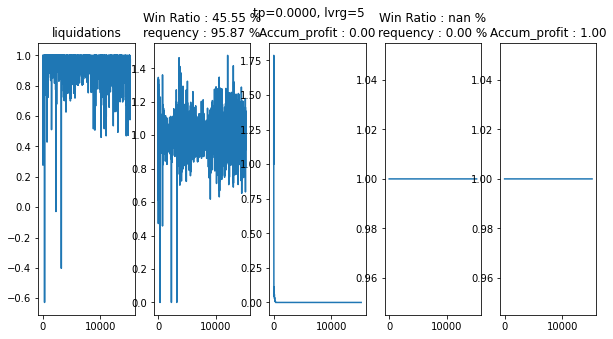

len(ohlc) : 15175
long_ep.shape : (15175, 1)
len(pr_list) : 15175
np.array(data_x).shape : (14504, 45, 6)


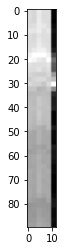

input_x.shape : (14504, 90, 12, 3)
input_x.dtype : float32
input_pr.shape : (14504, 1)
input_ud.shape : (14504, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pickle
from sklearn.model_selection import train_test_split

with open('./arima_result/arima_opt_profit_ls_only_long_result_%s.pickle' % interval, 'rb') as f:
  load_dict = pickle.load(f)

candis = list(load_dict.keys())
long_index = 0
leverage = 5
prev_x = None

seed = 1
random_state = 20
np.random.seed(seed)

for i in range(len(candis)):

  keys = [candis[i]]
  
  # if 'algo'.upper() not in candis[i]:
  #   continue
  if '2021-03-02 DOTUSDT.xlsx' in candis[i]:
    # print('')
    continue

  if '04-08' not in candis[i]:  # <-- 04-08 includes all timestamp range
    continue

  if 'theta'.upper() not in candis[i]:
    continue

  # plt.figure(figsize=(35, 10))
  # plt.suptitle('%s %s' % (interval, keys))


  #         get tp parameter        #

  # plt.subplot(1,10,3)
  # for key in keys:  
  #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])
  #   argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
  #   peak_tp = profit_result_dict[key]['tp_list'][argmax]
  #   # plt.axvline(peak_tp, linestyle='--')
  #   # plt.title('acc profit, max at %.4f' % (peak_tp))  

  # plt.subplot(1,10,4)
  # plt.title('max acc profit by leverage')  
  # for key in keys:  
  #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
  #   argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
  #   max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
  #   # plt.axvline(max_peak_tp, linestyle='--')
  #   # plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  for key in keys:  
    # print(profit_result_dict[key]['leverage_ap_list'])

    # for tp in [max_peak_tp]:

      # if tp == peak_tp:
      #   plt.subplot(1,10,5)
      # else:
      #   plt.subplot(1,10,6)

      #     leverage analysis     #
      ohlcv = load_dict[key]['ohlcv']
      # ohlcv = ohlcv.iloc[:-int(len(ohlcv) * 0.3)]  # exclude back_range
      # predictions = load_dict[key]['predictions']
      # err_ranges = load_dict[key]['err_ranges']
      print("ohlcv.index[0] :", ohlcv.index[0])
      print("ohlcv.index[-1] :", ohlcv.index[-1])

      predictions = ohlcv['close'].shift(1).values
      err_ranges = np.zeros_like(predictions)

      # leverage_list = profit_result_dict[key]['leverage_list']
      # temp_ap_list = list()
      # temp_pr_list = list()

      try:
        print('-------------- %s --------------' % key)
        result = get_back_result(ohlcv, predictions, err_ranges, tp=0, leverage=leverage, show_plot=True, reverse_short=False, show_detail=False)
        # temp_ap_list.append(result[2])
        # temp_pr_list.append(result[3])

        # if round(leverage) == 1:
        #   temp_pr_list = result[3]
        pr_list = result[3][long_index]

      except Exception as e:
        print(e)
        break    
  # break


      pd.set_option('display.max_rows', 500)
      pd.set_option('display.max_columns', 500)
      pd.set_option('display.width', 1000)

      #         clustering zone           #

      #       set data features : ohlc, v, ep
      ohlc = ohlcv.iloc[-len(predictions):, :4]
      vol = ohlcv.iloc[-len(predictions):, [4]]
      long_ep = np.array(predictions)
      long_ep = long_ep.reshape(-1, 1)

      ohlcv['u_wick'] = ohlcv['high'] / np.maximum(ohlcv['close'] , ohlcv['open'])
      ohlcv['d_wick'] = np.minimum(ohlcv['close'] , ohlcv['open']) / ohlcv['low']
      ohlcv['body'] = ohlcv['close'] / ohlcv['open']

      candle = ohlcv.iloc[-len(predictions):, -3:]


      print('len(ohlc) :', len(ohlc))
      print('long_ep.shape :', long_ep.shape)
      print('len(pr_list) :', len(pr_list))


      #       set params    #
      period = 45
      data_x, data_pr, data_updown = [], [], []
      key_i = i

      for i in range(period, len(predictions)):

        #   pr_list != 1 인 데이터만 사용한다
        # if 1:
        if pr_list[i] != 1:
          
          #   prediction 을 제외한 이전 데이터를 사용해야한다
          temp_ohlc = ohlc.iloc[i - period : i].values
          temp_long_ep = long_ep[i - period : i]
          temp_vol = vol.iloc[i - period : i].values
          temp_candle = candle.iloc[i - period : i].values

          # print(temp_ohlc.shape)
          # print(temp_long_ep.shape)
          # print(temp_vol.shape)
          # print(temp_candle.shape)
          # break

          #   stacking  
          # temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol, temp_candle))
          temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol))
          # temp_data = np.hstack((temp_ohlc, temp_vol))

          # temp_data = np.hstack((temp_ohlc, temp_long_ep))
          # temp_data = temp_vol

          #   scaler 설정

          #   ohlc & ep -> max_abs
          max_abs = MaxAbsScaler()
          temp_data[:, :5] = max_abs.fit_transform(temp_data[:, :5])


          # min_max = MinMaxScaler()
          # temp_data[:, :5] = min_max.fit_transform(temp_data[:, :5])


          #   vol -> min_max
          min_max = MinMaxScaler()
          temp_data[:, [5]] = min_max.fit_transform(temp_data[:, [5]])


          #   candle -> max_abs    
          # max_abs = MaxAbsScaler()
          # temp_data[:, -3:] = max_abs.fit_transform(temp_data[:, -3:])

          # min_max = MinMaxScaler()
          # temp_data[:, -3:] = min_max.fit_transform(temp_data[:, -3:])

          if np.isnan(np.sum(temp_data)):
            continue

          data_x.append(temp_data)
          data_pr.append(pr_list[i])
          data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


      print('np.array(data_x).shape :', np.array(data_x).shape)
      # print(data_x[0])


      #       Reshape data for image deep - learning     #
      _, row, col = np.array(data_x).shape

      input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)

      #     1c to 3c    #
      input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]
      input_x = np.array(resize_npy(input_x))


      input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
      input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
      print('input_x.shape :', input_x.shape)
      print('input_x.dtype :', input_x.dtype)
      print('input_pr.shape :', input_pr.shape)
      print('input_ud.shape :', input_ud.shape)

      
      # x_train_, x_test, pr_train_, pr_test, ud_train_, ud_test = train_test_split(input_x, input_pr, input_ud, test_size=0.4, shuffle=False, random_state=random_state)
      # x_train, x_val, pr_train, pr_val, ud_train, ud_val = train_test_split(x_train_, pr_train_, ud_train_, test_size=0.25, shuffle=False, random_state=random_state)

      #     do stacking   #
      #     do stacking   #
      if prev_x is None:
        prev_x = input_x
        prev_pr = input_pr
        prev_ud = input_ud
      else:
        total_x = np.vstack((prev_x, input_x))
        total_pr = np.vstack((prev_pr, input_pr))
        total_ud = np.vstack((prev_ud, input_ud))

        prev_x = total_x
        prev_pr = total_pr
        prev_ud = total_ud

        print('total_x.shape :', total_x.shape)
        print('total_pr.shape :', total_pr.shape)
        print('total_ud.shape :', total_ud.shape)
      # if prev_train_x is None:
      #   prev_train_x = x_train
      #   prev_val_x = x_val
      #   prev_test_x = x_test
        
      #   prev_train_pr = pr_train
      #   prev_val_pr = pr_val
      #   prev_test_pr = pr_test

      #   prev_train_ud = ud_train
      #   prev_val_ud = ud_val
      #   prev_test_ud = ud_test

      # else:

      #   total_train_x = np.vstack((prev_train_x, x_train))
      #   total_val_x = np.vstack((prev_val_x, x_val))
      #   total_test_x = np.vstack((prev_test_x, x_test))
      #   total_train_pr = np.vstack((prev_train_pr, pr_train))
      #   total_val_pr = np.vstack((prev_val_pr, pr_val))
      #   total_test_pr = np.vstack((prev_test_pr, pr_test))
      #   total_train_ud = np.vstack((prev_train_ud, ud_train))
      #   total_val_ud = np.vstack((prev_val_ud, ud_val))
      #   total_test_ud = np.vstack((prev_test_ud, ud_test))
        
      #   prev_train_x = total_train_x
      #   prev_val_x = total_val_x
      #   prev_test_x = total_test_x
        
      #   prev_train_pr = total_train_pr
      #   prev_val_pr = total_val_pr
      #   prev_test_pr = total_test_pr

      #   prev_train_ud = total_train_ud
      #   prev_val_ud = total_val_ud
      #   prev_test_ud = total_test_ud
        
      #   print("total_train_x.shape :", total_train_x.shape)
      #   print("total_val_x.shape :", total_val_x.shape)
      #   print("total_test_x.shape :", total_test_x.shape)
      #   print("total_train_pr.shape :", total_train_pr.shape)
      #   print("total_val_pr.shape :", total_val_pr.shape)
      #   print("total_test_pr.shape :", total_test_pr.shape)
      #   print("total_train_ud.shape :", total_train_ud.shape)
      #   print("total_val_ud.shape :", total_val_ud.shape)
      #   print("total_test_ud.shape :", total_test_ud.shape)

  break # --> use only one pair dataset

  #         chunks 로 나누지 않아도, generator 에서 batch_size 만큼만 load 할 것   #
  # try:
  #   if len(total_x) > 300000:
  #     break
  # except:
  #   pass

  
        

### Load Data

In [ ]:
period = 45
# x_save_path = current_path + 'npy/' + '%s_close_updown_x.npy' % period
# y_save_path = current_path + 'npy/' + '%s_close_updown_y.npy' % period
#         save to npy     #
# x_save_path = current_path + 'npy/' + '%s_close_updown_theta_x_ex.npy' % period
# y_save_path = current_path + 'npy/' + '%s_close_updown_theta_y_ex.npy' % period

# total_x = np.load(x_save_path)
# total_pr = np.load(y_save_path)

_, row, col, _ = input_x.shape



seed = 1
random_state = 20
np.random.seed(seed)
from sklearn.model_selection import train_test_split
#         train / test split      #
# x_train, x_test_, pr_train, pr_test_, ud_train, ud_test_ = train_test_split(re_input_x, total_pr, total_ud, test_size=0.4, shuffle=True, random_state=random_state)
x_train_, x_test, pr_train_, pr_test = train_test_split(input_x, input_pr, test_size=0.2, shuffle=False, random_state=random_state)
x_train, x_val, pr_train, pr_val = train_test_split(x_train_, pr_train_, test_size=0.25, shuffle=False, random_state=random_state)
# break
#         pr label   #
y_train = np.where(pr_train > 1, 1, 0)
y_test = np.where(pr_test > 1, 1, 0)
y_val = np.where(pr_val > 1, 1, 0)

del input_x

### **Model**

In [ ]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

%tensorflow_version 1.x

import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display

%matplotlib inline

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


gdrive_path = current_path

num_classes = 2

def FER_Model(input_shape=(row, col, 3)):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)
    # net = layers.AveragePooling2D(padding='same')(net)

    shortcut_1 = net

    # net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(128)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs=visible, outputs=net)
    # summary layers
    # print(model.summary())
    
    return model

In [ ]:
print(keras.__version__)
print(tf.__version__)

2.3.1
1.15.2


### **Data Split**

pr_train[:5] : [[0.82290965]
 [1.154621  ]
 [1.0678885 ]
 [1.3340611 ]
 [0.9096892 ]]
y_train[:5] : [[0]
 [1]
 [1]
 [1]
 [0]]
y_train.dtype : int64
x_train.shape : (8702, 90, 12, 3)
x_test.shape : (2901, 90, 12, 3)
x_val.shape : (2901, 90, 12, 3)
y_train.shape : (8702, 1)
y_test.shape : (2901, 1)
y_val.shape : (2901, 1)
np.unique(y_train, return_counts=True : (array([0, 1]), array([4880, 3822])) [1.27681842 1.        ]
np.unique(y_val, return_counts=True : (array([0, 1]), array([1533, 1368])) [1.12061404 1.        ]
np.unique(y_test, return_counts=True : (array([0, 1]), array([1484, 1417])) [1.04728299 1.        ]
class_weights : {0: 0.8915983606557377, 1: 1.1384092098377814}
np.isnan(np.sum(x_train)) : False
np.isnan(np.sum(x_val)) : False
np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_train)) : False
np.isnan(np.sum(y_val)) : False
np.isnan(np.sum(y_test)) : False
y_train_ohe.shape : (8702, 2)
y_val_ohe.shape : (2901, 2)
y_test_ohe.shape : (2901, 2)


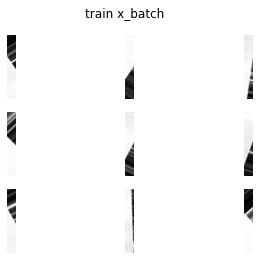

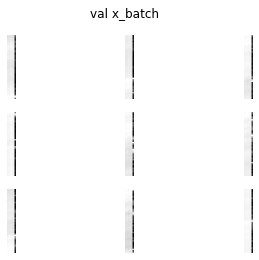

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight
# import cv2


_, row, col, _ = x_train.shape

#         pr label   #
# y_train = np.where(pr_train > 1, 1, 0)
# y_test = np.where(pr_test > 1, 1, 0)
# y_val = np.where(pr_val > 1, 1, 0)


seed = 1
random_state = 20
np.random.seed(seed)
# tf.random.set_seed(seed)

#         up label      #
# y_train = np.where(ud_train > 1, 1, 0)
# y_test = np.where(ud_test > 1, 1, 0)
# y_val = np.where(ud_val > 1, 1, 0)

print('pr_train[:5] :', pr_train[:5])
# print('ud_train[:5] :', ud_train[:5])
print('y_train[:5] :', y_train[:5])
print('y_train.dtype :', y_train.dtype)

print('x_train.shape :', x_train.shape)
print('x_test.shape :', x_test.shape)
print('x_val.shape :', x_val.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)
print('y_val.shape :', y_val.shape)

def class_ratio(in_list):

  return in_list / in_list[1]

print('np.unique(y_train, return_counts=True :', np.unique(y_train, return_counts=True), class_ratio(np.unique(y_train, return_counts=True)[1]))
print('np.unique(y_val, return_counts=True :', np.unique(y_val, return_counts=True), class_ratio(np.unique(y_val, return_counts=True)[1]))
print('np.unique(y_test, return_counts=True :', np.unique(y_test, return_counts=True), class_ratio(np.unique(y_test, return_counts=True)[1]))

label = y_train.reshape(-1, )
class_weights = class_weight.compute_class_weight('balanced', 
                                                    classes=np.unique(label),
                                                    y=label)
class_weights = dict(enumerate(class_weights))
print('class_weights :', class_weights)

# sample_weight = np.ones(shape=(len(y_train),))
# sample_weight[(y_train == 1).reshape(-1,)] = 1.5
# print('sample_weight[:20] :', sample_weight[:20])


print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(x_train)))
print('np.isnan(np.sum(x_val)) :', np.isnan(np.sum(x_val)))
print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))

print('np.isnan(np.sum(y_train)) :', np.isnan(np.sum(y_train)))
print('np.isnan(np.sum(y_val)) :', np.isnan(np.sum(y_val)))
print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

y_train_ohe = np_utils.to_categorical(y_train, num_classes)
y_val_ohe = np_utils.to_categorical(y_val, num_classes)
y_test_ohe = np_utils.to_categorical(y_test, num_classes)
print('y_train_ohe.shape :', y_train_ohe.shape)
print('y_val_ohe.shape :', y_val_ohe.shape)
print('y_test_ohe.shape :', y_test_ohe.shape)

datagen = ImageDataGenerator( 
    rotation_range = 45,
    # zoom_range = 0.5,
    # shear_range = 0.5,
    # horizontal_flip = True,
    # vertical_flip = True,
    # width_shift_range=0.5,
    # height_shift_range=0.5,
    # fill_mode = 'nearest'
    )

valgen = ImageDataGenerator( 
    )

datagen.fit(x_train)
valgen.fit(x_val)

batch_size = 16

for x_batch, _ in datagen.flow(x_train, y_train_ohe, batch_size=9):

    plt.suptitle("train x_batch")

    for i in range(0, 9): 
        plt.subplot(330 + 1 + i) 
        # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
        # cmapped = plt.cm.Set1(resized)
        # plt.imshow(cmapped)
        # plt.imshow(x_batch[i].reshape(row, col))
        plt.imshow(x_batch[i])
        plt.axis('off') 
    plt.show() 
    break

for x_batch, _ in valgen.flow(x_val, y_val_ohe, batch_size=9):

    plt.suptitle("val x_batch")

    for i in range(0, 9): 
        plt.subplot(330 + 1 + i) 
        # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
        # cmapped = plt.cm.Set1(resized)
        # plt.imshow(cmapped)
        # plt.imshow(x_batch[i].reshape(row, col))
        plt.imshow(x_batch[i])
        plt.axis('off') 
    plt.show() 
    break
    
train_flow = datagen.flow(x_train, y_train_ohe, batch_size=batch_size) 
val_flow = valgen.flow(x_val, y_val_ohe, batch_size=batch_size) 
# break



### **Training**

In [ ]:
(_, row, col, _) = x_train.shape
  
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'
model_name = 'classifier_%s_close_updown_pr_theta_non_shuffle_ex_maxabs.h5' % period

# model = keras.models.load_model(ckpt_path + model_name)

model = FER_Model(input_shape=(row, col, 3))
opt = Adam(lr=0.00001, decay=0.000005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

checkpoint = ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir=board_path,
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_loss', patience=40)
# callbacks_list = [checkpoint, checkpoint2, checkpoint3]
callbacks_list = [checkpoint, checkpoint2]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 1000
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(x_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    validation_data=val_flow,  
                    validation_steps=len(x_val) / batch_size,
                    shuffle=False)



Epoch 1/1000
 - 12s - loss: 0.7720 - accuracy: 0.5001 - val_loss: 0.7076 - val_accuracy: 0.4812

Epoch 00001: val_loss improved from inf to 0.70755, saving model to /content/drive/My Drive/Colab Notebooks/Project_Stock/ckpt/classifier_45_close_updown_pr_theta_non_shuffle_ex_maxabs.h5

Epoch 2/1000
 - 11s - loss: 0.7153 - accuracy: 0.4969 - val_loss: 0.5873 - val_accuracy: 0.5281

Epoch 00002: val_loss improved from 0.70755 to 0.58728, saving model to /content/drive/My Drive/Colab Notebooks/Project_Stock/ckpt/classifier_45_close_updown_pr_theta_non_shuffle_ex_maxabs.h5
Epoch 3/1000
 - 11s - loss: 0.7061 - accuracy: 0.4948 - val_loss: 0.7623 - val_accuracy: 0.5284

Epoch 00003: val_loss did not improve from 0.58728
Epoch 4/1000
 - 11s - loss: 0.7035 - accuracy: 0.4999 - val_loss: 0.8679 - val_accuracy: 0.5284

Epoch 00004: val_loss did not improve from 0.58728
Epoch 5/1000
 - 11s - loss: 0.6994 - accuracy: 0.5107 - val_loss: 0.6751 - val_accuracy: 0.4853

Epoch 00005: val_loss did not 

KeyboardInterrupt: ignored

In [ ]:
ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'
# model_name = 'classifier_45_close_updown_pr_theta_non_shuffle_ex_02008.h5'
# model_name = 'classifier_45_close_updown_pr_theta.h5'

model = keras.models.load_model(ckpt_path + model_name)

test_result.shape : (2901, 2)
pr_val.shape : (2901, 1)
y_test[:5] : [1 1 1 1 1]
y_score[:5] : [[0.06002754]
 [0.28203174]
 [0.8779696 ]
 [0.13999628]
 [0.24018347]]
y_test.shape : (2901, 1)
y_score.shape : (2901, 1)
len(y_test) : 2901


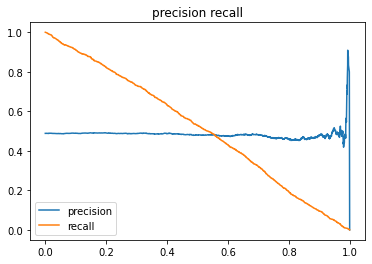

y_pred.shape : (2901,)
precision : 0.4825425246195166
recall : 0.3803810868031052

np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_test)) : False

origin ac_pr : 6.17001e-05
win ratio improvement 0.49 --> 0.48
accum_pr increased ! : 0.000 --> 0.021
thresh : 0.65


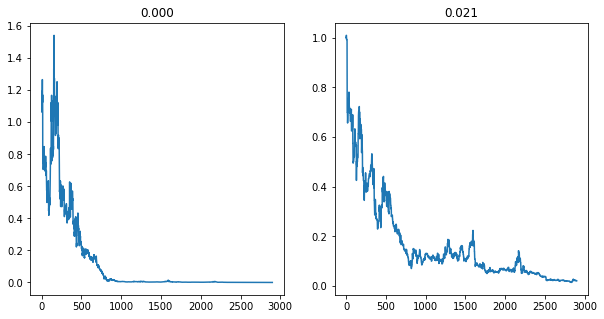

acc_pr_bythr : [0.02133044]


ValueError: ignored

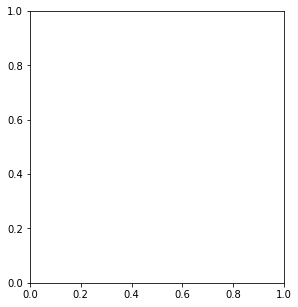

In [ ]:
test_result = model.predict(x_test)
# test_result = model.predict(test_set)

print('test_result.shape :', test_result.shape)
print('pr_val.shape :', pr_val.shape)

y_score = test_result[:, [1]]
print('y_test[:5] :', y_test.reshape(-1,)[:5])
# print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
print('y_score[:5] :', y_score[:5])
# print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

print('y_test.shape :', y_test.shape)
print('y_score.shape :', y_score.shape)

print('len(y_test) :', len(y_test))

#     precision recall curve   #
precision, recall, threshold = precision_recall_curve(y_test, y_score)
precision, recall = precision[:-1], recall[:-1]

plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
plt.show()
# print(y_pred)


threshold = [0.65]
# print('threshold :', threshold)
# break

acc_pr_bythr = []
for thresh in threshold:

  y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
  print('y_pred.shape :', y_pred.shape)
  # print('y_pred :', y_pred)

  #     compare precision     #

  print('precision :', precision_score(y_test, y_pred))
  print('recall :', recall_score(y_test, y_pred))
  print()

  print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
  print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

  # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
  # plt.show()  
  print()

  #     check win-ratio improvement     #
  cmat = confusion_matrix(y_test, y_pred)
  # print(cmat)
  # print(np.sum(cmat, axis=1))

  test_size = len(y_test)
  test_pr_list = pr_test
  print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

  org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
  ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
  print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

  # print('pr_test.shape :', pr_test.shape)

  # print(y_pred)
  # print(test_pr_list)
  pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
  # print('pred_pr_list.shape :', pred_pr_list.shape)

  if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
    print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
    print('thresh :', thresh)
    
  # if len(threshold) == 1:
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(np.cumprod(test_pr_list))
    plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
  # plt.show()

    plt.subplot(122)
    plt.plot(np.cumprod(pred_pr_list))
    plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
    plt.show()


  acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])

print('acc_pr_bythr :', acc_pr_bythr)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
# plt.show()
plt.subplot(122)
plt.plot(threshold, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.show()

#### **clustering output**

In [ ]:
# x_train_for_k = test_result.flatten().reshape(-1, 1)
x_train_for_k = test_result
print(x_train_for_k[:10])
# x_train_for_k = test_result[:, [1]]
pr_train = pr_test

print('x_train_for_k.shape :', x_train_for_k.shape)
print('pr_train.shape :', pr_train.shape)

K = range(2, 10)
s_dist = []
sil = []
for k in K:
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(x_train_for_k)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(x_train_for_k, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()





#   with best_k, label 별 pr_list 확인
km = KMeans(n_clusters=best_k)
km = km.fit(x_train_for_k)

labels = km.labels_

print(km.score(x_train_for_k))
print(len(labels), len(pr_train))





#   label 별로 profit 을 저장, 승률을 확인한다
label_types = np.unique(labels, return_counts=False)

label_pr_dict = {}
#   init dict   #
for label in label_types:
  label_pr_dict[label] = []
print(label_pr_dict)
# break

for i, (label, pr) in enumerate(zip(labels, pr_train)):
  label_pr_dict[label].append(pr[0])

  
# for label in label_types:
print(label_pr_dict)





def win_ratio(list_x):

  win_cnt = np.sum(np.array(list_x) > 1)
  return win_cnt / len(list_x)


def acc_pr(list_x):

  return np.cumprod(np.array(list_x))[-1]


for key in label_pr_dict:
  
  print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))





#     predict test && test 의 라벨에 따른 win_ratio 확인
# test_labels = km.predict(x_test)
# # print(test_labels)

# label_pr_dict = {}
# #   init dict   #
# for label in label_types:
#   label_pr_dict[label] = []
# print(label_pr_dict)
# # break

# for i, (label, pr) in enumerate(zip(test_labels, pr_test)):
#   label_pr_dict[label].append(pr[0])

# for key in label_pr_dict:

#   print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))

